In [1]:
import datasets
import utils

from ela import generator, random

predictions = utils.TestPredictions('nopoolrefinenet_dpn92_oc', mode='val').load_raw()
samples = utils.get_train_samples()
transforms = transforms = generator.TransformationsGenerator([])
dataset = datasets.AnalysisDataset(samples, './data/train', transforms, predictions)

In [2]:
import torch
from tqdm import tqdm
from metrics import mAP

data = {}


for i in tqdm(range(len(dataset))):   
    prediction, target, id = dataset[i]
    
    prediction_tensor = torch.FloatTensor(prediction).unsqueeze(0).unsqueeze(0)
    target_tensor = torch.FloatTensor(target).unsqueeze(0).unsqueeze(0)

    score = mAP(prediction_tensor > 0.5, target_tensor).item()
    
    data[id] = (prediction, target, score)


100%|██████████| 4000/4000 [03:02<00:00, 21.86it/s]


In [3]:
buckets_score = {
    0.25: [],
    0.5: [],
    0.75: [],
    1.00: [],
}

buckets_area = {
    0.001: [],
    0.10: [],
    0.15: [],
    0.20: [],
    0.25: [],
    0.5: [],
    0.75: [],
    1.00: [],
}

for key, (prediction, target, score) in data.items():
    prediction_tensor = torch.FloatTensor(prediction).unsqueeze(0).unsqueeze(0)
    target_tensor = torch.FloatTensor(target).unsqueeze(0).unsqueeze(0)

    for key in buckets_score:
            if score <= key:
                buckets_score[key].append(score)
                break

    for key in buckets_area:
        if target_tensor.sum() / (101*101) <= key:
            buckets_area[key].append(score)
            break

In [4]:
import numpy as np

overall = 0
for key, item in buckets_score.items():
    print(len(item) / 4000, np.mean(np.array(item)))
    overall += len(item) / 4000 * np.mean(np.array(item))
    
print(overall)

0.09225 0.01680216827205203
0.02975 0.4252100884914398
0.045 0.6594444470273124
0.833 0.9796518588087567
0.8599249986596406


In [5]:
overall = 0
for key, item in buckets_area.items():
    print(key, len(item) / 4000, np.mean(np.array(item)))
    overall += len(item) / 4000 * np.mean(np.array(item))
    
print(overall)

0.001 0.40175 0.9413814561553971
0.1 0.13275 0.522787192671537
0.15 0.04275 0.7485380062931463
0.2 0.03125 0.8191999969482422
0.25 0.02625 0.8771428511256263
0.5 0.1325 0.9115094307318049
0.75 0.114 0.9144736825112711
1.0 0.11875 0.8983157888682265
0.8599249986596406


In [6]:
buckets_score = {
    0.25: [],
    0.5: [],
    0.75: [],
    1.00: [],
}

buckets_area = {
    0.001: [],
    0.10: [],
    0.15: [],
    0.20: [],
    0.25: [],
    0.5: [],
    0.75: [],
    1.00: [],
}

for id, (prediction, target, score) in data.items():
    prediction_tensor = torch.FloatTensor(prediction).unsqueeze(0).unsqueeze(0)
    target_tensor = torch.FloatTensor(target).unsqueeze(0).unsqueeze(0)

    for key in buckets_score:
            if score <= key:
                buckets_score[key].append((id, prediction, target, score))
                break

    for key in buckets_area:
        if target_tensor.sum() / (101*101) <= key:
            buckets_area[key].append((id, prediction, target, score))
            break

In [35]:
import numpy as np

sorted_by_median = []
for id, (prediction, target, score) in data.items():
    sorted_by_median.append((id, prediction, target, score))
    
    
def sort_median(item):
    return np.abs(np.median(item[1]) - 0.5)
    
sorted_by_median = sorted(sorted_by_median, key=sort_median)

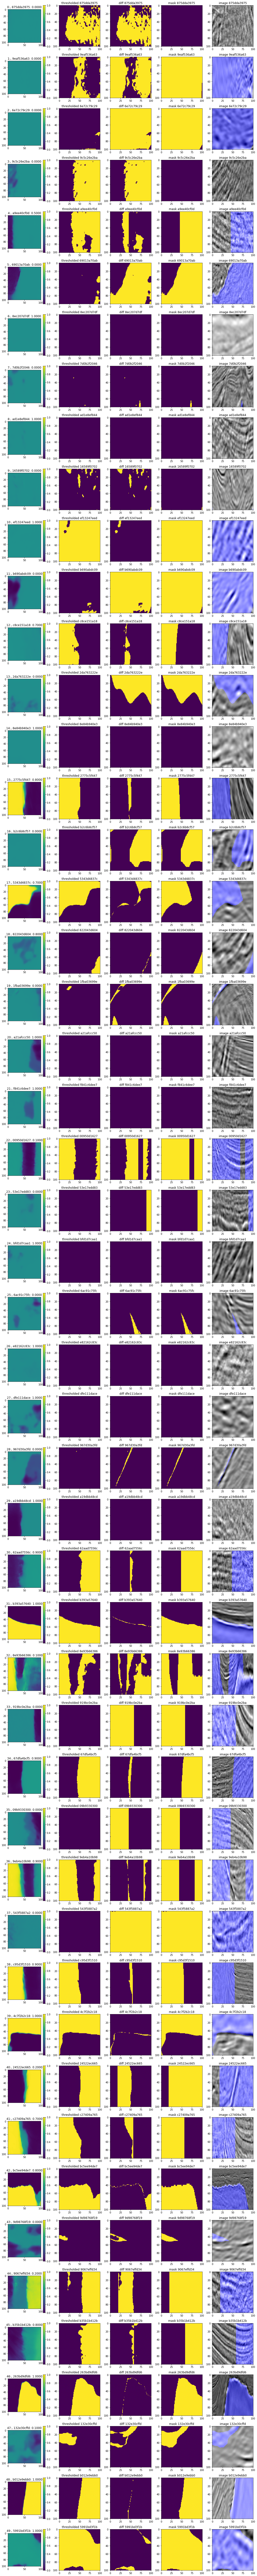

In [38]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import img_as_float
from skimage.io import imread

rows = 50
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
for i, (id, prediction, target, score) in zip(range(rows), sorted_by_median):
    im = ax[i][0].imshow(prediction, vmin = 0, vmax = 1)
    ax[i][0].set_title('{}:, {}: {:6.4f}'.format(i, id, score))
    ax[i][1].imshow(prediction > 0.5)
    ax[i][1].set_title('thresholded {}'.format(id))
    ax[i][2].imshow(np.abs(target - (prediction > 0.5)))
    ax[i][2].set_title('diff {}'.format(id))
    ax[i][3].imshow(target)
    ax[i][3].set_title('mask {}'.format(id))
    overlay = np.repeat(np.expand_dims(0.5*target, axis=2), 3, axis=2)
    overlay[:, :, [0, 1]] = 0
    ax[i][4].imshow(np.clip(overlay + img_as_float(imread(join('./data/train', 'images', id) + '.png')), 0, 1))
    ax[i][4].set_title('image {}'.format(id))    
    fig.colorbar(im, orientation='vertical', ax=ax[i][0])
    
plt.tight_layout()

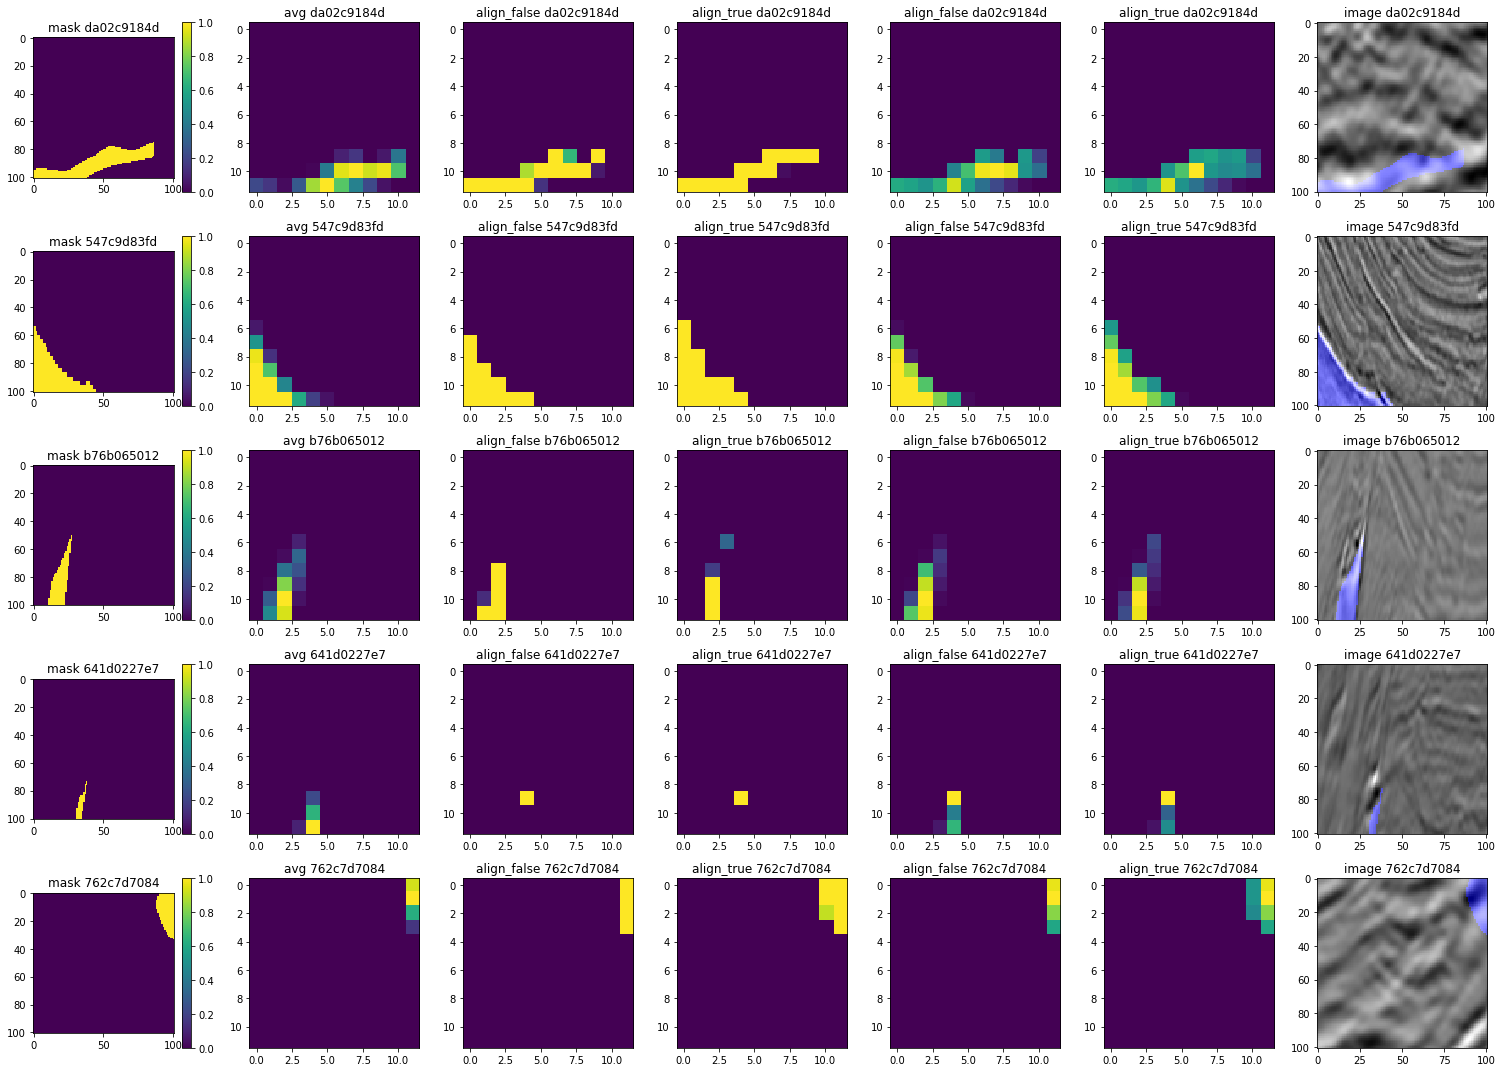

In [85]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.nn import functional as F

from skimage import img_as_float
from skimage.io import imread

rows = 5
cols = 7
fig, ax = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
for i, (id, prediction, target, score) in zip(range(rows), buckets_area[0.1]):
    im = ax[i][0].imshow(prediction, vmin = 0, vmax = 1)
    ax[i][0].imshow(target)
    ax[i][0].set_title('mask {}'.format(id))
    
    target_t = torch.from_numpy(target)
    target_t_pooled = F.avg_pool2d(target_t.unsqueeze(0).unsqueeze(0), 8).squeeze()
    target_pooled_avg = target_t_pooled.numpy()
    ax[i][1].imshow(target_pooled_avg)
    ax[i][1].set_title('avg {}'.format(id))
    
    target_t = torch.from_numpy(target)
    target_t_pooled = F.interpolate(target_t.unsqueeze(0).unsqueeze(0), scale_factor=1/8, mode='bilinear', align_corners=False).squeeze()
    target_pooled_align_false = target_t_pooled.numpy()    
    ax[i][2].imshow(target_pooled_align_false)
    ax[i][2].set_title('align_false {}'.format(id))
    
    
    target_t = torch.from_numpy(target)
    target_t_pooled = F.interpolate(target_t.unsqueeze(0).unsqueeze(0), scale_factor=1/8, mode='bilinear', align_corners=True).squeeze()
    target_pooled_align_true = target_t_pooled.numpy()    
    ax[i][3].imshow(target_pooled_align_true)
    ax[i][3].set_title('align_true {}'.format(id))
    
    ax[i][4].imshow((target_pooled_align_false + target_pooled_avg) / 0.5)
    ax[i][4].set_title('align_false {}'.format(id))
    
    ax[i][5].imshow((target_pooled_align_true + target_pooled_avg) / 0.5)
    ax[i][5].set_title('align_true {}'.format(id))
    
    overlay = np.repeat(np.expand_dims(0.5*target, axis=2), 3, axis=2)
    overlay[:, :, [0, 1]] = 0
    ax[i][6].imshow(np.clip(overlay + img_as_float(imread(join('./data/train', 'images', id) + '.png')), 0, 1))
    ax[i][6].set_title('image {}'.format(id))    
    fig.colorbar(im, orientation='vertical', ax=ax[i][0])
    
plt.tight_layout()